**Batch Normalization Forward**

In [ ]:
import torch
# Смысл в нормализации актитивации внутри батча
class MyBatchNorm:
    def __init__(self, num_features, eps=1e-5):
        # Параметры
        self.gamma = torch.ones(num_features, requires_grad=True)
        self.beta = torch.zeros(num_features, requires_grad=True)
        self.eps = eps
        # Среднее и дисперсия
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def __call__(self, x):
        if x.dim() == 2:
            # Fully-connected layer input: compute mean/var across batch (dim=0)
            batch_mean = x.mean(dim=0)
            batch_var = x.var(dim=0, unbiased=False)
        else:
            N, C, H, W = x.shape
            batch_mean = x.mean(dim=(0, 2, 3))
            batch_var = x.var(dim=(0, 2, 3), unbiased=False)
            batch_mean = batch_mean.view(1, C, 1, 1)
            batch_var = batch_var.view(1, C, 1, 1)

        # Нормализуем (x - mean) / sqrt(var + eps)
        x_hat = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
        # Scale and shift
        if x.dim() == 2:
            out = self.gamma * x_hat + self.beta
        else:
            # Reshape gamma, beta to (1,C,1,1) for broadcasting
            out = self.gamma.view(1, -1, 1, 1) * x_hat + self.beta.view(1, -1, 1, 1)
        return out

In [ ]:
x = torch.tensor([[-1.0,  2.0, 3.0], [ 4.0, -5.0, 6.0]])  # 2 samples, 3 features
bn = MyBatchNorm(num_features=3)
y = bn(x)
print("BatchNorm", y)


BatchNorm tensor([[-1.0000,  1.0000, -1.0000],
        [ 1.0000, -1.0000,  1.0000]], grad_fn=<AddBackward0>)


**Linear Layer Forward**

In [ ]:
class MyLinear:
    def __init__(self, in_features, out_features):
        self.W = torch.randn(in_features, out_features) * 0.01 # матрица + рандом
        self.b = torch.zeros(out_features) # вектор смещения
        self.W.requires_grad = True
        self.b.requires_grad = True

    def __call__(self, x):
        # умножаем входа и веса
        return x.matmul(self.W) + self.b


In [ ]:
x = torch.tensor([[1.0, 2.0, 3.0]])  # 1 sample, 3 features
lin = MyLinear(in_features=3, out_features=2)
y = lin(x)
print("Linear layer output:", y)
print("Output shape:", y.shape)

Linear layer output: tensor([[-0.0249,  0.0752]], grad_fn=<AddBackward0>)
Output shape: torch.Size([1, 2])


**Dropout Forward**

In [ ]:
# Смысл уменьшние переобучения, часть нейронов обнуляется с верояьностью p
class MyDropout:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x):
        if not torch.is_grad_enabled():
            #  Если не трейн, то пропускаем
            return x
        # Маска размером как x с рандромными числами от 0 до 1, если значение > p, оставляем, иначе зануляем.
        mask = (torch.rand_like(x) > self.p).float()
        #
        out = mask * x / (1 - self.p)
        return out

In [ ]:
x = torch.ones((4, 4))
drop = MyDropout(p=0.5)
y = drop(x)
print("Input tensor:\n", x)
print("After Dropout (p=0.5):\n", y)
print("Fraction of zeros in output ~", (y == 0).float().mean().item())

Input tensor:
 tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
After Dropout (p=0.5):
 tensor([[2., 2., 0., 0.],
        [0., 0., 0., 2.],
        [2., 2., 2., 2.],
        [2., 0., 2., 2.]])
Fraction of zeros in output ~ 0.375


**Median Filter**   
C, H, W - число каналов (1 - grey, 3 - rgb), H - ширина, W - высота   
Реализуйте медианный фильтр. Для текущего пикселя, пиксели, которые «попадают» в матрицу, сортируются, и выбирается медианное значение из отсортированного массива. Это значение и является выходным для текущего пикселя. Используйте только чистый torch. Покажите результат на примере для размера ядра 3, 5, 10

In [2]:
def median_filter(image_tensor, kernel_size):
    # Если двумерный, то добавим C = 1
    if image_tensor.dim() == 2:
        image = image_tensor.unsqueeze(0)
    else:
        image = image_tensor

    C, H, W = image.shape
    k = kernel_size
    if H < k or W < k:
        # Проверяем размер изображения, должен быть больше размера окна
        return image_tensor
    # ИСпользуем unfold чтобы получить патчи к на к, сначала генерируем все возможные по высоте (k на W), потом по ширине для каждого по высоте
    patches = image.unfold(1, k, 1).unfold(2, k, 1)
    out_H = patches.shape[1] # out_H = H - k + 1
    out_W = patches.shape[2]
    # После двух анфолдов для каждого пикселя, куда можно поставить центр окна k×k, есть свой патч
    patches = patches.contiguous().view(C, out_H, out_W, k*k)
    medians, _ = torch.median(patches, dim=3)
    # переводим в векторы, считаем медиану
    output = image.clone()
    offset = k // 2
    # оставлеяем границу исходной
    output[:, offset:offset+out_H, offset:offset+out_W] = medians
    if image_tensor.dim() == 2:
        return output[0]
    else:
        return output




In [5]:
import torch
img = torch.tensor([[1, 1, 1, 1, 1],
                    [1, 9, 1, 9, 1],
                    [1, 1, 1, 1, 1],
                    [1, 9, 1, 9, 1],
                    [1, 1, 1, 1, 1]], dtype=torch.float32)
print(img)
filtered = median_filter(img, kernel_size=1)
print(filtered)

tensor([[1., 1., 1., 1., 1.],
        [1., 9., 1., 9., 1.],
        [1., 1., 1., 1., 1.],
        [1., 9., 1., 9., 1.],
        [1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1.],
        [1., 9., 1., 9., 1.],
        [1., 1., 1., 1., 1.],
        [1., 9., 1., 9., 1.],
        [1., 1., 1., 1., 1.]])


**Data Augmentation Transform Classes**   
Реализуйте следующие классы (указана сигнатура init):

    BaseTransform(p: float) [базовый класс для всех трансформаций]
    RandomCrop(p: float, **kwargs)
    RandomRotate(p: float, **kwargs)
    RandomZoom(p: float, **kwargs) {*}
    ToTensor()
    Compose(list[BaseTransform])

Последний класс должен принимать на вход список инстансов трех других. При вызове метода call он должен последовательно вызывать трансформации из списка. При вызове каждого из них с вероятностью p должно применяться изменение изображения, с вероятностью 1-p должно возвращаться исходное изображение. Класс входного изображения у всех классов - PIL.Image, выходного тоже. Класс ToTensor должен принимать на вход PIL.Image, возвращать - torch.Tensor.

In [5]:
import random
from PIL import Image
import numpy as np
import torch

class BaseTransform:
    def __init__(self, p: float):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return self.apply(img)
        return img

    def apply(self, img):
        raise NotImplementedError



class RandomCrop(BaseTransform):
    def __init__(self, p: float, size):
        super().__init__(p)

        if isinstance(size, tuple):
            self.target_h, self.target_w = size
        else:
            self.target_h = self.target_w = size

    def apply(self, img: Image.Image):
        w, h = img.size
        # рандомно выбираем верхнюю левую уординату для кропа
        left = random.randint(0, w - self.target_w)
        top = random.randint(0, h - self.target_h)
        right = left + self.target_w
        bottom = top + self.target_h
        return img.crop((left, top, right, bottom))


class RandomRotate(BaseTransform):
    def __init__(self, p: float, degrees=30):
        super().__init__(p)

        if isinstance(degrees, tuple):
            self.min_angle, self.max_angle = degrees
        else:
            self.min_angle, self.max_angle = -degrees, degrees

    def apply(self, img: Image.Image):
        angle = random.uniform(self.min_angle, self.max_angle)
        # Вращаем изображение(угл выбирам рандомно из промежутка), углы могут быть отрезаны тк размер ихображения должен быть равен исходному
        return img.rotate(angle, resample=Image.Resampling.BILINEAR, fillcolor=(0, 0, 0))


class RandomZoom(BaseTransform):
    def __init__(self, p: float, scale=(0.8, 1.2)):
        super().__init__(p)

        if isinstance(scale, tuple):
            self.min_factor, self.max_factor = scale


        if self.min_factor <= 0:
            self.min_factor = 0.1  # проверяем, чтобы не было отрицательных значений
        if self.min_factor > self.max_factor:
            self.min_factor, self.max_factor = self.max_factor, self.min_factor

    def apply(self, img: Image.Image):
        w, h = img.size
        # выбираем рандомно в  [min_factor, max_factor]
        factor = random.uniform(self.min_factor, self.max_factor)
        # Если фактор имееет очень маленькое изменение, то просто возвращаем изображение
        if abs(factor - 1.0) < 1e-3:
            return img
        if factor > 1.0:
          # Вычисляем что нужно вырезать, делаем цетральный кроп, делаем оригинальный ресайз -> изображение как-бы приблизили
            new_w = max(1, int(w / factor))
            new_h = max(1, int(h / factor))
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            cropped = img.crop((left, top, left + new_w, top + new_h))
            return cropped.resize((w, h), resample=Image.Resampling.BILINEAR)
        else:
            # Делаем картинку меньше, втавляем на черный фон исходного размера -> картинку как-бы отдалили
            new_w = max(1, int(w * factor))
            new_h = max(1, int(h * factor))
            resized = img.resize((new_w, new_h), resample=Image.Resampling.BILINEAR)
            new_img = Image.new('RGB', (w, h), color=(0, 0, 0))
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            new_img.paste(resized, (left, top))
            return new_img

class ToTensor(BaseTransform):
    def __init__(self):
        # применяем всегда, независимо от p
        super().__init__(p=1.0)

    def apply(self, img: Image.Image):
        # переводим PIL в NumPy array
        arr = np.array(img)
        if arr.ndim == 2:  # если grayscale
            arr = arr[:, :, None]

        arr = arr.transpose((2, 0, 1))
        tensor = torch.from_numpy(arr).float()
        # Делаем нормализацию деля на размерность для 8 битного изображения
        return tensor / 255.0


class Compose:
    def __init__(self, transforms):

        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img




In [6]:

from PIL import ImageDraw
test_img = Image.new('RGB', (10, 10), color=(50, 50, 50))
draw = ImageDraw.Draw(test_img)
draw.rectangle([0, 0, 4, 4], fill=(255, 0, 0))
draw.rectangle([5, 5, 9, 9], fill=(0, 0, 255))


random.seed(42)
transforms = Compose([
    RandomRotate(p=1.0, degrees=45),
    RandomZoom(p=1.0, scale=(0.5, 1.5))])
out_a = transforms(test_img.copy())
random.seed(42)
out_b = transforms(test_img.copy())

pixels_a = list(out_a.getdata())
pixels_b = list(out_b.getdata())
print("Проверка воспроизводимости", pixels_a == pixels_b)




Проверка воспроизводимости True


**CNN**   
Примените трансформации из задания 3 в качестве трансформаций датасета из практики 2.2. В этом задании можно пользоваться torch.nn, за исключением трансформаций. Покажите, как меняются лосс и метрики на трейне и на тесте в зависимости от количества и вероятностей трансформаций. Проведите обучение на большом количестве эпох. Опишите, что вы наблюдаете для каждого случая и какая есть разница, если применить трансформации. Предоставьте графики в matplotlib или tensorboard (+1 балл) в ноутбуке (в случае с tensorboard можно в отдельном окне) с наглядными примерами

In [7]:
import os
import random
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

dataset_path = kagglehub.dataset_download("devanshagarwal9/artistic-styles")
# Фиксируем сиды для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

IMG_SIZE = 128  # итоговый размер входа для CNN

def upscale_min_side(img: Image.Image, min_size: int) -> Image.Image:
    # Если минимальная сторона изображения меньше min_size, увеличиваем изображение, сохраняя пропорции.
    w, h = img.size
    m = min(w, h)
    if m >= min_size:
        return img
    scale = min_size / m
    new_w = int(w * scale) + 1
    new_h = int(h * scale) + 1
    return img.resize((new_w, new_h), resample=Image.Resampling.BILINEAR)


def center_crop_square(img: Image.Image, size: int) -> Image.Image:
    # Центровой кроп квадратом
    img = upscale_min_side(img, size)
    w, h = img.size
    left = (w - size) // 2
    top = (h - size) // 2
    right = left + size
    bottom = top + size
    return img.crop((left, top, right, bottom))


# Грузим изображения универсальным лоадером, создаем метки классов и путей

def collect_image_paths(root_dir: str, exts=(".jpg", ".jpeg", ".png", ".bmp")) -> Tuple[List[str], List[int], Dict[str, int]]:

    image_paths = []
    labels = []
    class_to_idx: Dict[str, int] = {}
    next_idx = 0

    for current_root, dirs, files in os.walk(root_dir):
        rel = os.path.relpath(current_root, root_dir)
        if rel == ".":
            continue

        class_name = os.path.basename(current_root)
        if class_name.startswith("."):
            continue

        if class_name not in class_to_idx:
            class_to_idx[class_name] = next_idx
            next_idx += 1

        for fname in files:
            if fname.lower().endswith(exts):
                full_path = os.path.join(current_root, fname)
                image_paths.append(full_path)
                labels.append(class_to_idx[class_name])

    return image_paths, labels, class_to_idx


image_paths, labels, class_to_idx = collect_image_paths(dataset_path)
num_classes = len(class_to_idx)

# Разбиваем на train test
def train_test_split_paths(
    image_paths: List[str],
    labels: List[int],
    test_ratio: float = 0.2,
    seed: int = 42
):

    indices = list(range(len(image_paths)))
    random.Random(seed).shuffle(indices)

    test_size = int(len(indices) * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    def select(idx_list):
        return [image_paths[i] for i in idx_list], [labels[i] for i in idx_list]

    train_paths, train_labels = select(train_indices)
    test_paths, test_labels = select(test_indices)
    return train_paths, train_labels, test_paths, test_labels


train_paths, train_labels, test_paths, test_labels = train_test_split_paths(
    image_paths, labels, test_ratio=0.2, seed=SEED
)

print(len(train_paths))
print(len(test_paths))



class ArtisticStylesDataset(Dataset):
# Проводим подготовку изображений
    def __init__(self, paths: List[str], labels: List[int], transform=None, is_train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        img = Image.open(path).convert("RGB")
        img = upscale_min_side(img, IMG_SIZE)

        if self.is_train and self.transform is not None:
            img = self.transform(img)
        else:
            img = center_crop_square(img, IMG_SIZE)

        # Переводим в тензор
        img = self.to_tensor(img)

        return img, label


class CNN(nn.Module):

    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Using Colab cache for faster access to the 'artistic-styles' dataset.
Device: cuda
409
102


In [8]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(config_name,
                train_dataset,
                test_dataset,
                num_epochs=20,
                batch_size=64,
                lr=1e-3):

    print(config_name)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    model = CNN(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(
            f"Epoch [{epoch+1:02d}/{num_epochs:02d}] "
            f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
            f"Test loss: {test_loss:.4f}, acc: {test_acc:.4f}"
        )

    return history

In [11]:
def make_base_crop():
    return RandomCrop(p=1.0, size=(IMG_SIZE, IMG_SIZE))

# 1) Без аугментаций, только crop

# 2) Слабая аугментация все преобразования p=0.5
moderate_transform = Compose([
    RandomRotate(p=0.5, degrees=30),
    RandomZoom(p=0.5, scale=(0.8, 1.2)),
    make_base_crop(),
])

# 2) Сильная аугментация все преобразования p=0.9
strong_transform = Compose([
    RandomRotate(p=0.9, degrees=45),
    RandomZoom(p=0.9, scale=(0.6, 1.4)),
    make_base_crop(),
])


test_dataset = ArtisticStylesDataset(test_paths, test_labels, transform=None, is_train=False)


NUM_EPOCHS = 50
BATCH_SIZE = 64
LR = 1e-3

results = {}

# Конфигурация 1
train_dataset_no_aug = ArtisticStylesDataset(
    train_paths,
    train_labels,
    transform=None,
    is_train=True
)
history_no_aug = train_model(
    "no_augmentations",
    train_dataset_no_aug,
    test_dataset,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR
)
results["no_augmentations"] = history_no_aug

# Конфигурация 2
train_dataset_moderate = ArtisticStylesDataset(
    train_paths,
    train_labels,
    transform=moderate_transform,
    is_train=True
)
history_moderate = train_model(
    "moderate_augmentations_p0.5",
    train_dataset_moderate,
    test_dataset,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR
)
results["moderate_augmentations_p0.5"] = history_moderate

# Конфигурация 3
train_dataset_strong = ArtisticStylesDataset(
    train_paths,
    train_labels,
    transform=strong_transform,
    is_train=True
)
history_strong = train_model(
    "strong_augmentations_p0.9",
    train_dataset_strong,
    test_dataset,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR
)
results["strong_augmentations_p0.9"] = history_strong

no_augmentations
Epoch [01/50] Train loss: 2.2372, acc: 0.1345 | Test loss: 2.1573, acc: 0.1667
Epoch [02/50] Train loss: 2.1180, acc: 0.1663 | Test loss: 2.1516, acc: 0.1471
Epoch [03/50] Train loss: 2.0529, acc: 0.2054 | Test loss: 2.1455, acc: 0.2157
Epoch [04/50] Train loss: 2.0210, acc: 0.1834 | Test loss: 2.1393, acc: 0.1569
Epoch [05/50] Train loss: 1.9734, acc: 0.2494 | Test loss: 2.1167, acc: 0.1863
Epoch [06/50] Train loss: 1.9248, acc: 0.2543 | Test loss: 2.1758, acc: 0.1961
Epoch [07/50] Train loss: 1.8714, acc: 0.3496 | Test loss: 2.2247, acc: 0.2255
Epoch [08/50] Train loss: 1.7848, acc: 0.3447 | Test loss: 2.2079, acc: 0.2255
Epoch [09/50] Train loss: 1.6533, acc: 0.4328 | Test loss: 2.2719, acc: 0.2157
Epoch [10/50] Train loss: 1.5132, acc: 0.5110 | Test loss: 2.4592, acc: 0.2549
Epoch [11/50] Train loss: 1.3787, acc: 0.5526 | Test loss: 2.3999, acc: 0.1765
Epoch [12/50] Train loss: 1.1995, acc: 0.5917 | Test loss: 3.2392, acc: 0.2157
Epoch [13/50] Train loss: 1.0464, a

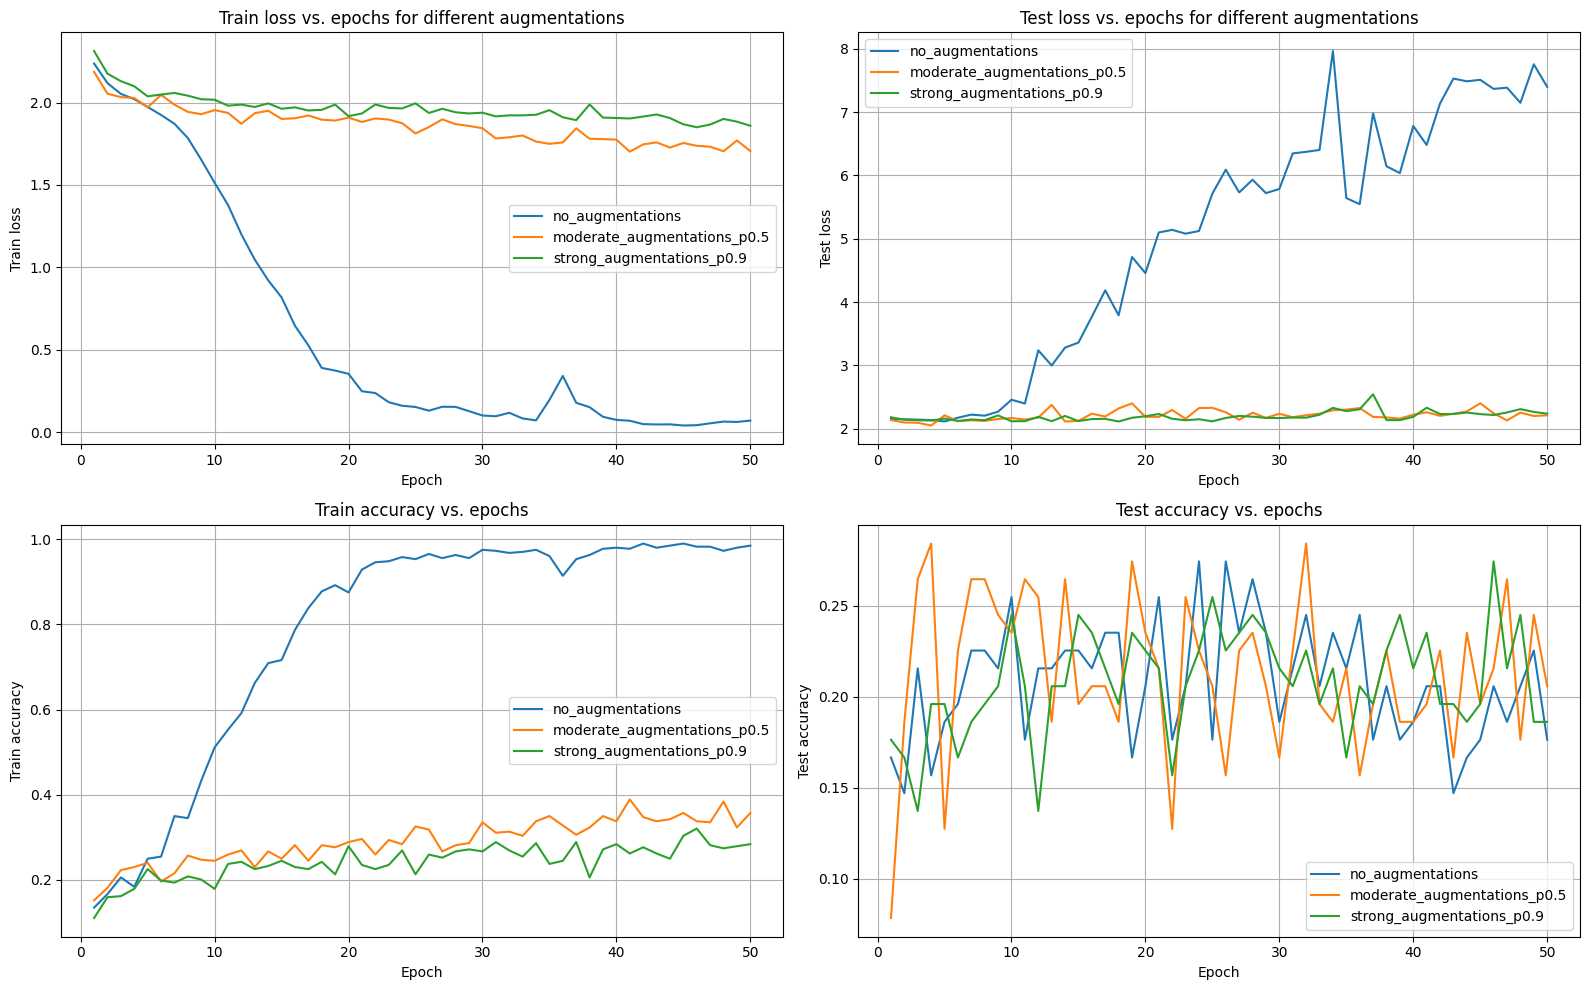

In [12]:

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
for name, hist in results.items():
    plt.plot(epochs, hist["train_loss"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.title("Train loss vs. epochs for different augmentations")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for name, hist in results.items():
    plt.plot(epochs, hist["test_loss"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Test loss")
plt.title("Test loss vs. epochs for different augmentations")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
for name, hist in results.items():
    plt.plot(epochs, hist["train_acc"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Train accuracy")
plt.title("Train accuracy vs. epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for name, hist in results.items():
    plt.plot(epochs, hist["test_acc"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.title("Test accuracy vs. epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
